In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ads = pd.read_csv('Ads.csv', index_col=['Date'], parse_dates=['Date'])

# Data analysis

In [5]:
ads.head()

,ads
Date,
2017-08-03 00:00:00,49136
2017-08-03 01:00:00,46450
2017-08-03 02:00:00,46355
2017-08-03 03:00:00,43748
2017-08-03 04:00:00,42281


In [12]:
len(ads)

2085

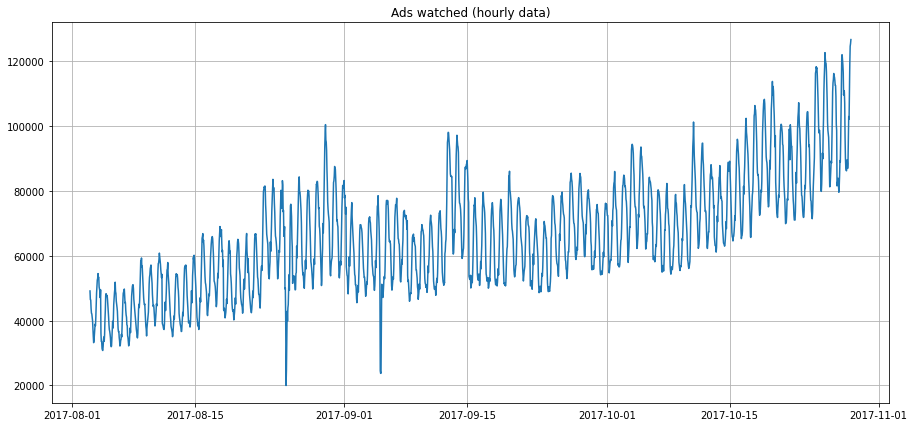

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(ads.ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

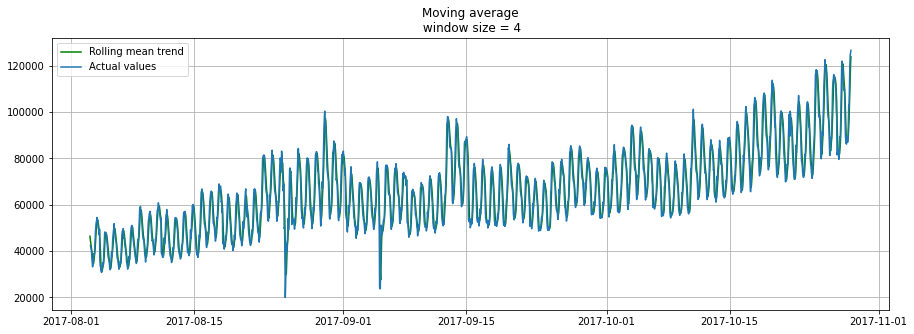

In [17]:
plotMovingAverage(ads, 4)

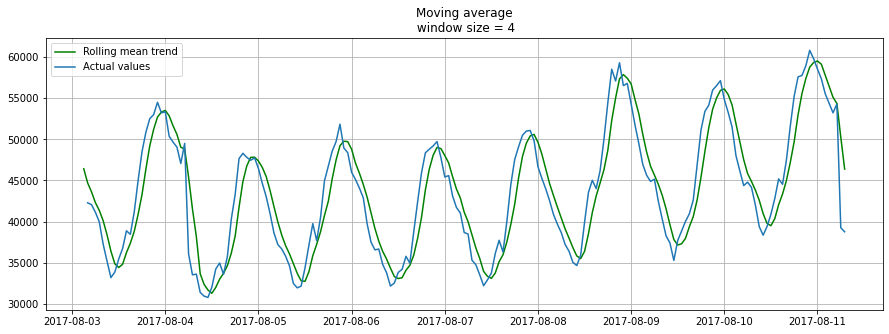

In [14]:
plotMovingAverage(ads.head(200), 4)

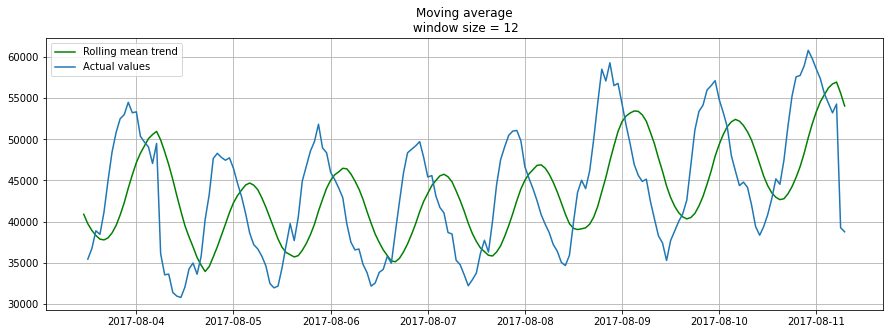

In [15]:
plotMovingAverage(ads.head(200), 12)

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/cosmin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
analysis = ads.ads.copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

In [28]:
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid


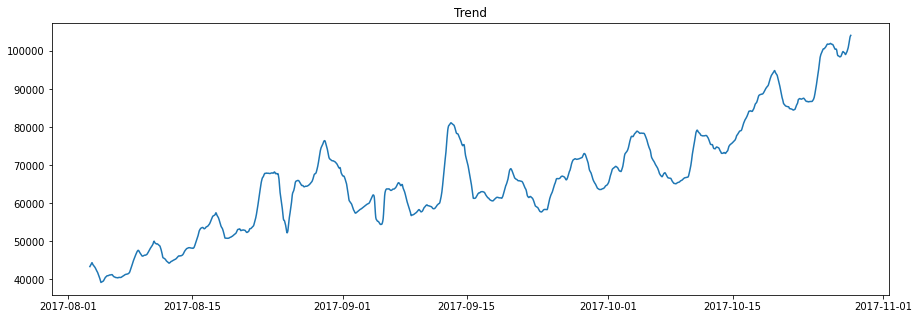

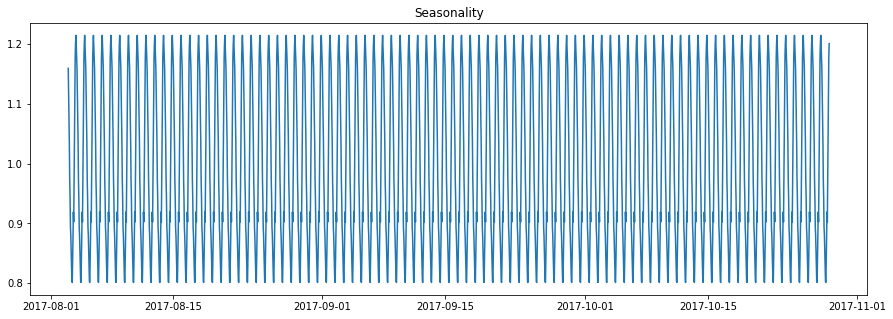

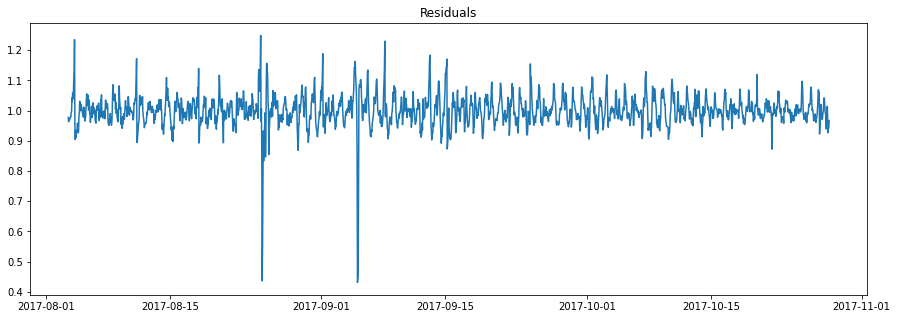

In [34]:
plt.figure(figsize=(15,5))
plt.plot(trend.dropna())
plt.title("Trend")
plt.figure(figsize=(15,5))
plt.plot(seasonal.dropna())
plt.title("Seasonality")
plt.figure(figsize=(15,5))
plt.plot(residual.dropna())
plt.title("Residuals");

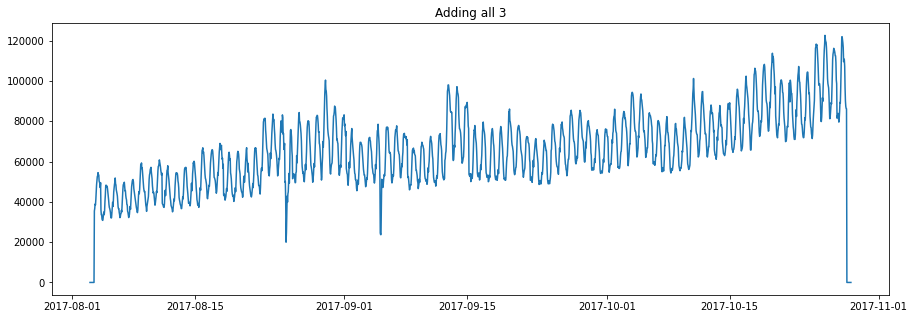

In [37]:
plt.figure(figsize=(15,5))
plt.plot(residual.fillna(1) * trend.fillna(1) * seasonal)
plt.title("Adding all 3");

# Model building

## 1. NNet pentru toata seria

In [109]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [44]:
ads.head(10).ads.to_numpy()

array([49136, 46450, 46355, 43748, 42281, 42059, 41136, 39974, 37261,
       35194])

In [46]:
ads.ads.iloc[10]

33188

In [69]:
def sample_ts(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size - 1):
        X.append(data.iloc[i:i+window_size].to_numpy())
        y.append(data.iloc[i+window_size+1])
    
    return np.array(X), np.array(y)

In [70]:
X, y = sample_ts(ads.ads, window_size=32)

In [71]:
X.shape

(2052, 32)

In [72]:
len(y)

2052

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [102]:
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)

MinMaxScaler()

In [103]:
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

In [104]:
scaler = MinMaxScaler()
scaler.fit(y_train.reshape(-1,1))
y_train = scaler.transform(y_train.reshape(-1,1))
y_test = scaler.transform(y_test.reshape(-1,1))

In [105]:
model = Sequential([
    layers.Input(shape=(32)),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [106]:
model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/100
29/29 [==============================] - 1s 6ms/step - loss: 0.2773 - mse: 0.2773 - mae: 0.3876 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.1110
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0660 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0471
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0372 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0537
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0345 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0391
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0311 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0407
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0292 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0380
Epoch 7/100
29/29 [===

Epoch 51/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0226 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0284
Epoch 52/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0225 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0271
Epoch 53/100
29/29 [==============================] - 0s 2ms/step - loss: 9.8182e-04 - mse: 9.8182e-04 - mae: 0.0218 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0289
Epoch 54/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0234 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0267
Epoch 55/100
29/29 [==============================] - 0s 2ms/step - loss: 9.7976e-04 - mse: 9.7976e-04 - mae: 0.0218 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0311
Epoch 56/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0240 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0267


Epoch 100/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0223 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0277


In [96]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 832us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0276  


[0.0013242207933217287, 0.0013242207933217287, 0.02760501764714718]

In [107]:
preds = model.predict(X_test)

In [110]:
r2_score(preds, y_test)

0.9477737213133798

In [111]:
r2_score(scaler.inverse_transform(y_test), scaler.inverse_transform(preds))

0.9450086039232538

In [112]:
mean_squared_error(preds, y_test)

0.001368883387325497

In [113]:
mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(preds))

12032228.540863631

In [114]:
mean_absolute_error(preds, y_test)

0.02765974730614668

In [115]:
mean_absolute_error(scaler.inverse_transform(y_test), scaler.inverse_transform(preds))

2593.211733919903

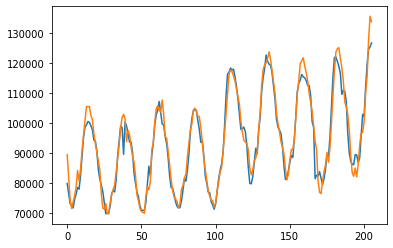

In [117]:
plt.plot(np.arange(len(y_test)), scaler.inverse_transform(y_test))
plt.plot(np.arange(len(preds)), scaler.inverse_transform(preds))

## 2. LSTM pentru estimare 

In [120]:
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

In [124]:
model = Sequential([
    layers.LSTM(32, input_shape=(1, 32), return_sequences=True),
    layers.LSTM(32),
    layers.Dense(1, activation='linear')
])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

In [125]:
model.fit(
    x=X_train_lstm,
    y=y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_lstm, y_test)
)

Epoch 1/100
29/29 [==============================] - 3s 26ms/step - loss: 0.1853 - mae: 0.3933 - mse: 0.1853 - val_loss: 0.0743 - val_mae: 0.2288 - val_mse: 0.0743
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0153 - mae: 0.1013 - mse: 0.0153 - val_loss: 0.0383 - val_mae: 0.1524 - val_mse: 0.0383
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0121 - mae: 0.0896 - mse: 0.0121 - val_loss: 0.0225 - val_mae: 0.1196 - val_mse: 0.0225
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0107 - mae: 0.0841 - mse: 0.0107 - val_loss: 0.0179 - val_mae: 0.1052 - val_mse: 0.0179
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0077 - mae: 0.0708 - mse: 0.0077 - val_loss: 0.0104 - val_mae: 0.0771 - val_mse: 0.0104
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 0.0505 - mse: 0.0044 - val_loss: 0.0046 - val_mae: 0.0502 - val_mse: 0.0046
Epoch 7/100
29/29 [==

Epoch 51/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0259 - mse: 0.0013 - val_loss: 0.0021 - val_mae: 0.0355 - val_mse: 0.0021
Epoch 52/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0260 - mse: 0.0015 - val_loss: 0.0015 - val_mae: 0.0281 - val_mse: 0.0015
Epoch 53/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0258 - mse: 0.0014 - val_loss: 0.0018 - val_mae: 0.0321 - val_mse: 0.0018
Epoch 54/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0268 - mse: 0.0014 - val_loss: 0.0024 - val_mae: 0.0388 - val_mse: 0.0024
Epoch 55/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0266 - mse: 0.0015 - val_loss: 0.0016 - val_mae: 0.0298 - val_mse: 0.0016
Epoch 56/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0272 - mse: 0.0015 - val_loss: 0.0024 - val_mae: 0.0387 - val_mse: 0.0024
Epoch 57/100
29/

In [126]:
model.evaluate(X_test_lstm, y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.0023 - mae: 0.0382 - mse: 0.0023


[0.0023445566184818745, 0.03818976879119873, 0.0023445566184818745]

In [128]:
preds = model.predict(X_test_lstm)

In [133]:
r2_score(y_test, preds)

0.9058134551065984

In [134]:
r2_score(scaler.inverse_transform(y_test), scaler.inverse_transform(preds))

0.9058134429747753

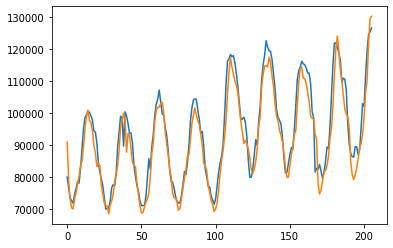

In [131]:
plt.plot(np.arange(len(y_test)), scaler.inverse_transform(y_test))
plt.plot(np.arange(len(preds)), scaler.inverse_transform(preds))

# Evaluarea modelelor

In [140]:
def evaluate_model(model, scaler, X_test, y_test):
    preds = model.predict(X_test)
    r2_unscaled = r2_score(y_test, preds)
    r2_scaled = r2_score(scaler.inverse_transform(y_test), scaler.inverse_transform(preds))
    
    mse_unscaled = mean_squared_error(y_test, preds)
    mse_scaled = mean_squared_error(y_test, preds)
    
    mae_unscaled = mean_absolute_error(y_test, preds)
    mae_scaled = mean_absolute_error(scaler.inverse_transform(y_test), scaler.inverse_transform(preds))
    
    print("R2 scores: Scaled: {} | Unscaled: {}".format(r2_scaled, r2_unscaled))
    print("Mean squared errors: Scaled: {} | Unscaled: {}".format(mse_scaled, mse_unscaled))
    print("Mean absolute errors: Scaled: {} | Unscaled: {}".format(mae_scaled, mae_unscaled))
    
    plt.plot(np.arange(len(y_test)), scaler.inverse_transform(y_test))
    plt.plot(np.arange(len(preds)), scaler.inverse_transform(preds))
    plt.show()

In [176]:
def predict_sequence(model, scaler, last_seq, samples):
    preds = []
    x = last_seq
    for i in range(samples):
        pred = model.predict(np.array([x]))[0][0]
        preds.append(pred)
        x = np.roll(x, -1, axis=1)
        x[0, -1] = pred
    
    plt.plot(np.arange(len(last_seq[0])), last_seq[0])
    plt.plot(np.arange(len(last_seq[0]) - 1, len(last_seq[0]) + len(preds) - 1), preds)
    
    return preds

R2 scores: Scaled: 0.9058134429747753 | Unscaled: 0.9058134551065984
Mean squared errors: Scaled: 0.0023445558407814604 | Unscaled: 0.0023445558407814604
Mean absolute errors: Scaled: 3580.443416262136 | Unscaled: 0.038189765831175525


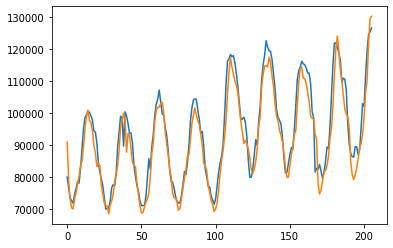

In [142]:
evaluate_model(model, scaler, X_test_lstm, y_test)

In [166]:
last_seq = np.roll(X_test_lstm[-1], -1, axis=1)
last_seq[0,-1] = y_test[-1]

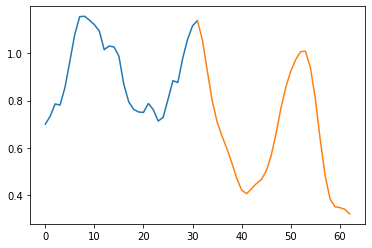

In [177]:
preds = predict_sequence(model, scaler, last_seq, 32)